# REGRESSION

In [2]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set_style('darkgrid')

## HELPER FUNCTIONS

In [3]:
def create_regressor_columns_string(columns):
  # Join all independent variables to define the formula used by the model
  regressor_columns = list(filter(lambda x: x != 'impression_count',columns))
  regressor_columns_string = "+".join(regressor_columns)
  return regressor_columns_string

In [4]:
def perform_regression(regression_df, significant_variables):
    # Define formula without cross terms
    regressor_columns_string = create_regressor_columns_string(significant_variables)
    # Fit model
    mod = smf.ols(formula=f'impression_count ~ {regressor_columns_string}', data=regression_df)
    res = mod.fit()
    return res

In [5]:
def keep_significant_var(p_values):
    # Filter p-values < 0.05
    p_values = p_values[p_values < 0.05]

    # Get significant variables
    significant_variables = list(p_values.index)
    # Remove intercept if significant
    try:
        significant_variables.remove('Intercept')
    except:
        pass

    return significant_variables

## REGRESSIONS WITH LOG TRANSFORMED VARIABLES AND THRESHOLDING

In [6]:
def regression(path, threshold=1e2):
    # Load data
    regression_df_pd = pd.read_csv(path)
    regression_df_pd = regression_df_pd.drop('tweet_text', axis=1)
    
    #======================#
    #   FIRST REGRESSION   #
    #======================#
    significant_variables = list(regression_df_pd.columns)
    res = perform_regression(regression_df_pd, significant_variables)
    p_values = res.pvalues
    nb_variables_before = len(p_values)
    
    #======================#
    #   SECOND REGRESSION  #
    #======================#
    # Filter out data if impression_count < threshold
    regression_df_pd = regression_df_pd[regression_df_pd['impression_count'] >= threshold].copy()

    # Perform new regression with significant variables
    res_threshold = perform_regression(regression_df_pd, significant_variables)

    #======================#
    #   THIRD REGRESSION   #
    #======================#
    # Apply log transformation to independent variables
    for var in regression_df_pd.columns:
            regression_df_pd[var] = regression_df_pd[var].apply(lambda x: np.log(1+x))

    # Perform new regression with significant variables
    res_log = perform_regression(regression_df_pd, significant_variables)
    p_values = res_log.pvalues

    #======================#
    #   FINAL RESULTS      #
    #======================#
    # Filter p-values < 0.05
    significant_variables = keep_significant_var(p_values)
    nb_variables_after = len(significant_variables)

    # Perform new regression with significant variables
    res_final = perform_regression(regression_df_pd, significant_variables)

    print(f'Number of discarded variables: {nb_variables_before - nb_variables_after}')
    print(f'Significant variables ({len(significant_variables)}): {significant_variables}')

    #======================#
    #   SAVE AS HTML       #
    #======================#
    # Save first res as html
    res_html = res.summary().as_html()
    name = path.split('/')[-1].split('.')[0][:-3]
    path_root = os.path.join('/'.join(os.getcwd().split('/')[:-1]), "data", "regression", "html_regression")
    path = os.path.join(path_root, name+".html")
    with open(path, 'w') as f:
        f.write(res_html)

    # Save second res as html
    res_thresh_html = res_threshold.summary().as_html()
    path_opti = os.path.join(path_root, name+"_threshold.html")
    with open(path_opti, 'w') as f:
        f.write(res_thresh_html)

    # Save third res as html
    res_log_html = res_log.summary().as_html()
    path_log = os.path.join(path_root, name+"_log.html")
    with open(path_log, 'w') as f:
        f.write(res_log_html)

    # Save final res as html
    res_final_html = res_final.summary().as_html()
    path_final = os.path.join(path_root, name+"_final.html")
    with open(path_final, 'w') as f:
        f.write(res_final_html)

    return res, res_threshold, res_log, res_final

In [7]:
path_data = '../data/regression/american_celebrities_regression_dff.csv'
res_reg = regression(path_data)

display(res_reg[0].summary())
display(res_reg[1].summary())
display(res_reg[2].summary())
display(res_reg[3].summary())

Number of discarded variables: 8
Significant variables (15): ['dummy_celebrities', 'dummy_famouscomedians', 'dummy_gameshow', 'dummy_jimmyfallon', 'dummy_kardashianjenner', 'dummy_kevinhart', 'dummy_moviestv', 'dummy_pop', 'dummy_television', 'mentions_count', 'tweet_external_urls_count', 'tweet_length', 'tweet_medias_count', 'tweet_period', 'followers_count']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     11.85
Date:                Thu, 25 May 2023   Prob (F-statistic):           1.75e-37
Time:                        19:23:11   Log-Likelihood:                -16910.
No. Observations:                1051   AIC:                         3.387e+04
Df Residuals:                    1028   BIC:                         3.398e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                          -6.431e+05   4.23e+05     -1.520      0.129   -1.47e+06    1.87e+05
dummy_celebrities                  -1.589e+05   2.78e+05     -0.572      0.567   -7.04e+05    3.86e+05
dummy_competitionshows              3.166e+04   6.85e+05      0.046      0.963   -1.31e+06    1.38e+06
dummy_entertainmentleisurebusiness  6.368e+04   3.13e+05      0.203      0.839   -5.51e+05    6.79e+05
dummy_famouscomedians                7.53e+05   3.35e+05      2.247      0.025    9.53e+04    1.41e+06
dummy_famousfamilies                9.115e+04   4.64e+05      0.196      0.844    -8.2e+05       1e+06
dummy_gameshow                      5.191e+05   1.81e+06      0.287      0.774   -3.03e+06    4.06e+06
dummy_jimmyfallon                  -3.758e+05   4.41e+05     -0.851      0.395   -1.24e+06     4.9e+05
dummy_kardashianjenner              1.668e+05   4.85e+05      0.344      0.731   -7.84e+05    1.12e+06
dummy_kevinhart                    -3.048e+05   3.29e+05     -0.927      0.354    -9.5e+05     3.4e+05
dummy_moviestv                      1.754e+06    6.8e+05      2.577      0.010    4.18e+05    3.09e+06
dummy_music                         2.491e+05   2.89e+05      0.860      0.390   -3.19e+05    8.17e+05
dummy_pop                           4.712e+05   3.05e+05      1.544      0.123   -1.28e+05    1.07e+06
dummy_television                   -1.756e+06   6.85e+05     -2.565      0.010    -3.1e+06   -4.12e+05
dummy_thatsmyjam                   -7.014e+05   1.78e+06     -0.394      0.694   -4.19e+06    2.79e+06
hashtags_count                     -3.118e+05   1.36e+05     -2.294      0.022   -5.79e+05    -4.5e+04
mentions_count                     -1.196e+05   7.08e+04     -1.689      0.092   -2.59e+05    1.94e+04
tweet_external_urls_count            1.49e+05   1.72e+05      0.864      0.388   -1.89e+05    4.87e+05
tweet_length                       -1076.5252   1253.718     -0.859      0.391   -3536.663    1383.612
tweet_medias_count                  5.839e+05    8.7e+04      6.713      0.000    4.13e+05    7.55e+05
tweet_period                       -1.731e+04   1.42e+04     -1.218      0.223   -4.52e+04    1.06e+04
tweet_sentiment                     1.855e+05   1.65e+05      1.122      0.262   -1.39e+05     5.1e+05
followers_count                        0.0265      0.004      6.395      0.000       0.018       0.035
==============================================================================
Omnibus:                     1417.519   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           325665.544
Skew:                           7.221   Prob(JB):                         0.00
Kurtosis:                      88.019   Cond. No.                     2.14e+09
==========

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     9.566
Date:                Thu, 25 May 2023   Prob (F-statistic):           1.43e-28
Time:                        19:23:11   Log-Likelihood:                -13405.
No. Observations:                 828   AIC:                         2.686e+04
Df Residuals:                     805   BIC:                         2.697e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                          -7.114e+05   5.45e+05     -1.306      0.192   -1.78e+06    3.58e+05
dummy_celebrities                   1.436e+05   3.53e+05      0.407      0.684    -5.5e+05    8.37e+05
dummy_competitionshows              2.093e+05   8.11e+05      0.258      0.796   -1.38e+06     1.8e+06
dummy_entertainmentleisurebusiness  2.217e+05   3.97e+05      0.558      0.577   -5.58e+05       1e+06
dummy_famouscomedians               1.055e+06   4.59e+05      2.298      0.022    1.54e+05    1.96e+06
dummy_famousfamilies                4.547e+05   5.53e+05      0.823      0.411    -6.3e+05    1.54e+06
dummy_gameshow                      6.538e+05   2.03e+06      0.323      0.747   -3.32e+06    4.63e+06
dummy_jimmyfallon                  -6.924e+05   5.61e+05     -1.233      0.218   -1.79e+06    4.09e+05
dummy_kardashianjenner              8429.9884   5.76e+05      0.015      0.988   -1.12e+06    1.14e+06
dummy_kevinhart                    -1.197e+05    4.7e+05     -0.255      0.799   -1.04e+06    8.04e+05
dummy_moviestv                      2.315e+06   8.68e+05      2.667      0.008    6.11e+05    4.02e+06
dummy_music                         2.259e+05   3.66e+05      0.617      0.537   -4.92e+05    9.44e+05
dummy_pop                           7.286e+05   3.91e+05      1.865      0.063   -3.83e+04     1.5e+06
dummy_television                   -2.445e+06   8.64e+05     -2.830      0.005   -4.14e+06   -7.49e+05
dummy_thatsmyjam                   -1.123e+06   2.02e+06     -0.557      0.578   -5.08e+06    2.84e+06
hashtags_count                     -4.328e+05   1.71e+05     -2.524      0.012   -7.69e+05   -9.61e+04
mentions_count                     -7.218e+04   9.59e+04     -0.752      0.452   -2.61e+05    1.16e+05
tweet_external_urls_count          -1.777e+04   2.25e+05     -0.079      0.937   -4.59e+05    4.23e+05
tweet_length                       -1516.1534   1453.473     -1.043      0.297   -4369.197    1336.890
tweet_medias_count                  5.188e+05   1.09e+05      4.778      0.000    3.06e+05    7.32e+05
tweet_period                       -2.325e+04   1.75e+04     -1.329      0.184   -5.76e+04    1.11e+04
tweet_sentiment                     1.418e+05   2.06e+05      0.690      0.491   -2.62e+05    5.45e+05
followers_count                        0.0291      0.005      5.669      0.000       0.019       0.039
==============================================================================
Omnibus:                     1057.844   Durbin-Watson:                   1.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171830.396
Skew:                           6.513   Prob(JB):                         0.00
Kurtosis:                      72.361   Cond. No.                     1.99e+09
==========

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     41.15
Date:                Thu, 25 May 2023   Prob (F-statistic):          1.19e-115
Time:                        19:23:11   Log-Likelihood:                -1313.8
No. Observations:                 828   AIC:                             2674.
Df Residuals:                     805   BIC:                             2782.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            -12.0786      2.599     -4.647      0.000     -17.180      -6.977
dummy_celebrities                      1.3137      0.252      5.206      0.000       0.818       1.809
dummy_competitionshows                 0.9957      0.537      1.855      0.064      -0.058       2.049
dummy_entertainmentleisurebusiness     0.0537      0.263      0.204      0.838      -0.463       0.570
dummy_famouscomedians                  2.4027      0.365      6.584      0.000       1.686       3.119
dummy_famousfamilies                   0.6549      0.371      1.765      0.078      -0.073       1.383
dummy_gameshow                        -3.0321      1.326     -2.287      0.022      -5.634      -0.430
dummy_jimmyfallon                     -2.1803      0.401     -5.442      0.000      -2.967      -1.394
dummy_kardashianjenner                -1.2328      0.387     -3.186      0.001      -1.992      -0.473
dummy_kevinhart                       -2.2694      0.363     -6.246      0.000      -2.983      -1.556
dummy_moviestv                         1.1540      0.572      2.019      0.044       0.032       2.276
dummy_music                           -0.2388      0.239     -0.999      0.318      -0.708       0.230
dummy_pop                              0.8073      0.267      3.021      0.003       0.283       1.332
dummy_television                      -1.3129      0.570     -2.305      0.021      -2.431      -0.195
dummy_thatsmyjam                       1.0655      1.322      0.806      0.420      -1.529       3.660
hashtags_count                        -0.0461      0.145     -0.318      0.751      -0.331       0.239
mentions_count                        -0.4885      0.100     -4.887      0.000      -0.685      -0.292
tweet_external_urls_count              0.8734      0.154      5.658      0.000       0.570       1.176
tweet_length                           0.2338      0.072      3.229      0.001       0.092       0.376
tweet_medias_count                     1.0386      0.106      9.781      0.000       0.830       1.247
tweet_period                           0.1589      0.067      2.381      0.017       0.028       0.290
tweet_sentiment                       -0.0768      0.073     -1.047      0.295      -0.221       0.067
followers_count                        1.2716      0.149      8.524      0.000       0.979       1.564
==============================================================================
Omnibus:                       53.547   Durbin-Watson:                   1.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.289
Skew:                          -0.305   Prob(JB):                     1.71e-32
Kurtosis:                       4.967   Cond. No.                     1.18e+03
==========

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       impression_count   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     59.62
Date:                Thu, 25 May 2023   Prob (F-statistic):          9.10e-120
Time:                        19:23:11   Log-Likelihood:                -1318.3
No. Observations:                 828   AIC:                             2669.
Df Residuals:                     812   BIC:                             2744.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -14.8662      2.284     -6.508      0.000     -19.350     -10.382
dummy_celebrities             1.1284      0.234      4.818      0.000       0.669       1.588
dummy_famouscomedians         2.4781      0.331      7.489      0.000       1.829       3.128
dummy_gameshow               -1.1423      0.421     -2.716      0.007      -1.968      -0.317
dummy_jimmyfallon            -2.2323      0.380     -5.868      0.000      -2.979      -1.486
dummy_kardashianjenner       -0.6583      0.228     -2.889      0.004      -1.106      -0.211
dummy_kevinhart              -2.4858      0.330     -7.544      0.000      -3.133      -1.839
dummy_moviestv                0.8178      0.497      1.644      0.101      -0.159       1.794
dummy_pop                     0.4520      0.216      2.088      0.037       0.027       0.877
dummy_television             -0.8205      0.443     -1.853      0.064      -1.690       0.049
mentions_count               -0.4731      0.098     -4.831      0.000      -0.665      -0.281
tweet_external_urls_count     0.8897      0.153      5.815      0.000       0.589       1.190
tweet_length                  0.2360      0.069      3.407      0.001       0.100       0.372
tweet_medias_count            1.0131      0.102      9.979      0.000       0.814       1.212
tweet_period                  0.1597      0.067      2.395      0.017       0.029       0.291
followers_count               1.4334      0.132     10.875      0.000       1.175       1.692
==============================================================================
Omnibus:                       57.537   Durbin-Watson:                   1.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.969
Skew:                          -0.340   Prob(JB):                     1.35e-34
Kurtosis:                       5.014   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## COEFFICIENTS PLOTS

In [8]:
# Assign significant levels stars to each variable name
def assign_stars(row):
    p_value = float(row['P>|t|'])
    name = row[0].replace('_', ' ').title()
    if p_value <= 0.01:
        return name + ' ***'
    elif p_value <= 0.05:
        return name + ' **'
    elif p_value <= 0.1:
        return name + ' *'
    else:
        return name

In [31]:
# Define function to output plot of the model coefficients

def coefplot(results):
    ### PREPARE DATA FOR PLOTTING
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names and drop the extra row with column labels
    coef_df.columns = coef_df.iloc[0]
    columns = coef_df.iloc[:,0]
    coef_df=coef_df.drop(0)

    # Rename column 0 and append * ** or *** for significance levels
    # coef_df["index"] = coef_df.apply(lambda x: assign_stars(x), axis=1)

    # Set index to variable names
    coef_df = coef_df.set_index(coef_df.apply(lambda x: assign_stars(x), axis=1))
    coef_df = coef_df.drop(coef_df.columns[0], axis=1)

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    coef_df['errors'] = errors

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### PLOT COEFFICIENTS
    variables = list(coef_df.index.values)
    coef_df['variables'] = variables

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar', ax=ax, color='none', fontsize=15, ecolor='steelblue', capsize=0, yerr='errors', legend=False)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), marker='o', s=80, y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    # Set title & labels
    #plt.title('Coefficients of Features - 95% Confidence Intervals',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=15)
    ax.set_xlabel('',fontsize=15)

    # Rotate y ticks and move to the right side
    ax.yaxis.tick_right()
    plt.yticks(rotation=90, fontsize=15)
    
    plt.show()

    return list(columns[2:])

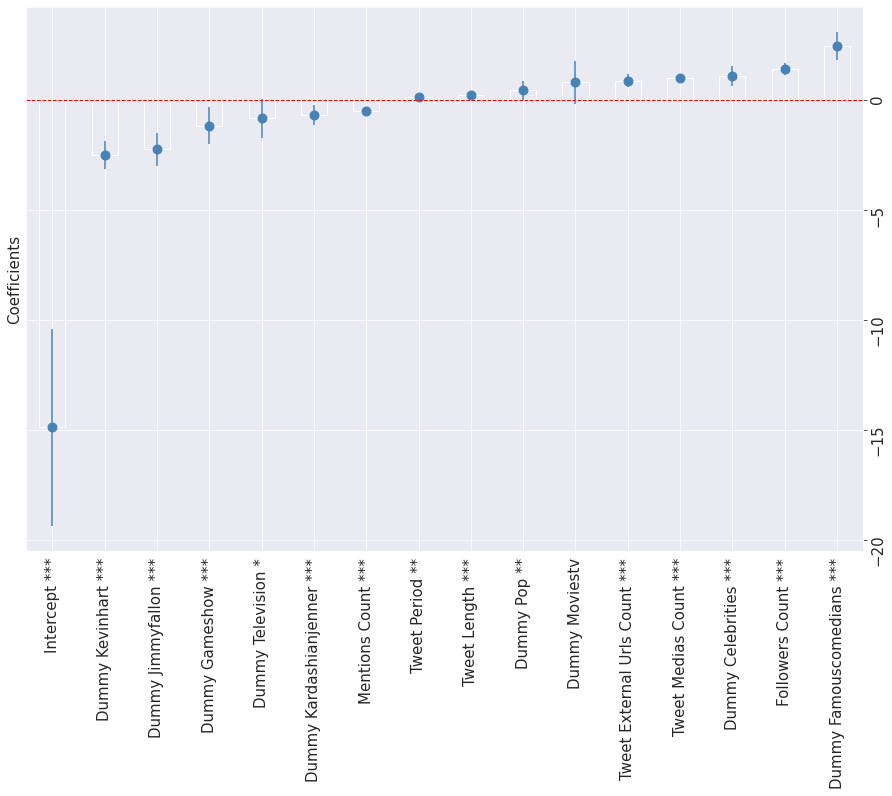

In [38]:
significant_columns = coefplot(res_reg[3])

In [35]:
regression_df_pd = pd.read_csv('../data/regression/american_celebrities_regression_dff.csv')[significant_columns + ['impression_count']]

regression_df_pd = regression_df_pd[regression_df_pd['impression_count'] >= 1e2].copy()

    # Perform new regression with significant variables

    #======================#
    #   THIRD REGRESSION   #
    #======================#
    # Apply log transformation to independent variables
for var in regression_df_pd.columns:
    regression_df_pd[var] = regression_df_pd[var].apply(lambda x: np.log(1+x))

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# perform regression with splitting into training and validation set and compute mse
def perform_regression_with_split(df, significant_columns):
    # Split into train and validation set
    train, validation = train_test_split(df, test_size=0.2, random_state=42)

    # Perform regression on train set
    res = perform_regression(train, significant_columns)

    # Compute mse on validation set
    y_pred = res.predict(validation[significant_columns])
    y_true = validation['impression_count']
    mse = mean_squared_error(y_true, y_pred)
    print(f'MSE: {mse}')

    return res

In [42]:
perform_regression_with_split(regression_df_pd, significant_columns)

MSE: 1.3877276637084692


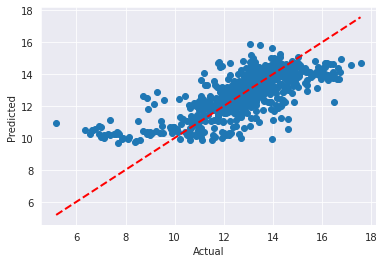

In [46]:
# plot predicted impression count vs actual impression count
def plot_predicted_vs_actual(df, significant_columns):
    res = perform_regression(df, significant_columns)
    y_pred = res.predict(df[significant_columns])
    y_true = df['impression_count']

    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.scatter(y_true, y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

plot_predicted_vs_actual(regression_df_pd, significant_columns)